In [9]:
import random
import numpy as np

def generate_cities(num_cities):
    cities = []
    for _ in range(num_cities):
        x = random.randint(-100, 100)
        y = random.randint(-100, 100)
        z = random.randint(0, 50)
        cities.append((x, y, z))
    return cities

# Example: Generate 5 cities
cities = generate_cities(9)
print("Generated cities:", cities)


Generated cities: [(37, -80, 42), (79, -58, 17), (-14, -3, 22), (-94, -20, 10), (50, -92, 46), (-79, 38, 36), (47, -56, 6), (-72, -38, 16), (76, -89, 10)]


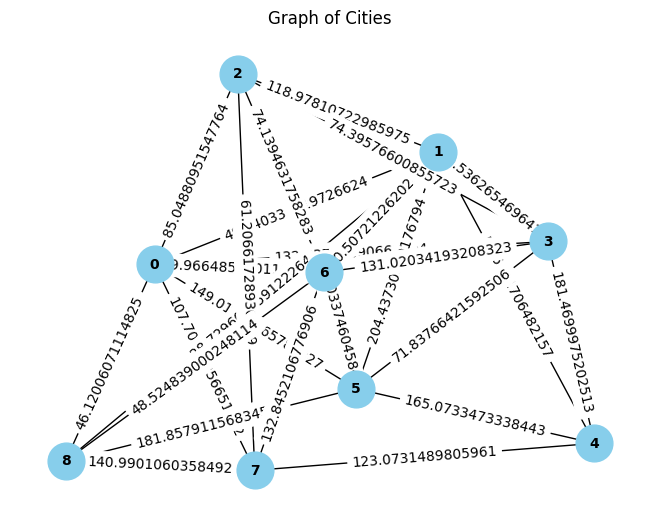

In [10]:
import math
import networkx as nx
import matplotlib.pyplot as plt

def calculate_distance(city1, city2):
    x1, y1, z1 = city1
    x2, y2, z2 = city2
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)

def create_graph(cities, connections_percentage=1.0, symmetrical=True):
    num_cities = len(cities)
    graph = {i: {} for i in range(num_cities)}
    
    for i in range(num_cities):
        for j in range(i + 1, num_cities):
            if random.random() < connections_percentage:
                cost = calculate_distance(cities[i], cities[j])
                if symmetrical:
                    # Adjust cost for asymmetrical scenario
                    cost *= 1.1 if cities[i][2] < cities[j][2] else 0.9
                graph[i][j] = cost
                graph[j][i] = cost
    
    return graph

# Tworzenie grafu
graph = create_graph(cities, connections_percentage=0.8, symmetrical=True)

# Rysowanie grafu
G = nx.Graph()
for i, neighbors in graph.items():
    for j, cost in neighbors.items():
        G.add_edge(i, j, weight=cost)

pos = nx.spring_layout(G)  # Ustalenie pozycji węzłów
nx.draw(G, pos, with_labels=True, node_size=700, node_color="skyblue", font_size=10, font_weight="bold")
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Graph of Cities")
plt.show()


In [11]:
def tsp_bfs(graph, start):
    queue = [(start, [start], 0)]
    num_cities = len(graph)
    shortest_path = None
    min_cost = float('inf')

    while queue:
        current_city, path, cost = queue.pop(0)

        if len(path) == num_cities and start in graph[current_city]:
            # Return to starting city
            cost += graph[current_city][start]
            if cost < min_cost:
                shortest_path = path + [start]
                min_cost = cost
        else:
            for neighbor, edge_cost in graph[current_city].items():
                if neighbor not in path:
                    new_path = path + [neighbor]
                    new_cost = cost + edge_cost
                    queue.append((neighbor, new_path, new_cost))

    return shortest_path, min_cost

def tsp_dfs(graph, start):
    stack = [(start, [start], 0)]
    num_cities = len(graph)
    shortest_path = None
    min_cost = float('inf')

    while stack:
        current_city, path, cost = stack.pop()

        if len(path) == num_cities and start in graph[current_city]:
            # Return to starting city
            cost += graph[current_city][start]
            if cost < min_cost:
                shortest_path = path + [start]
                min_cost = cost
        else:
            for neighbor, edge_cost in graph[current_city].items():
                if neighbor not in path:
                    new_path = path + [neighbor]
                    new_cost = cost + edge_cost
                    stack.append((neighbor, new_path, new_cost))

    return shortest_path, min_cost

# Example: Solve TSP using BFS and DFS
start_city = 0
shortest_path_bfs, min_cost_bfs = tsp_bfs(graph, start_city)
shortest_path_dfs, min_cost_dfs = tsp_dfs(graph, start_city)


In [12]:
from queue import PriorityQueue

def admissible_heuristic(graph, current_city, remaining_cities):
    """
    Heurystyka ta jest obliczana jako minimalny koszt potrzebny do połączenia wszystkich pozostałych miast, co daje nam dolne ograniczenie na koszt odwiedzenia tych miast.
    """
    mst_cost = 0
    visited = set()
    visited.add(current_city)
    remaining = set(remaining_cities)
    while remaining:
        min_edge = float('inf')
        min_neighbor = None
        for city in visited:
            for neighbor, cost in graph[city].items():
                if neighbor in remaining and cost < min_edge:
                    min_edge = cost
                    min_neighbor = neighbor
        if min_neighbor is not None:
            visited.add(min_neighbor)
            remaining.remove(min_neighbor)
            mst_cost += min_edge
        else:
            # Jeśli nie można znaleźć ścieżki do pozostałych miast, zwracamy nieskończoność
            return float('inf')
    return mst_cost


def inadmissible_heuristic(graph, current_city, start_city):
    """
    Obliczanie heurystyki niedopuszczalnej dla algorytmu A*
    poprzez oszacowanie pozostałej odległości do miasta startowego.
    """
    return calculate_distance(cities[current_city], cities[start_city])

def tsp_a_star(graph, start_city):
    """
    Solve TSP using A* algorithm with both admissible and inadmissible heuristics.
    """
    priority_queue = PriorityQueue()
    num_cities = len(graph)
    initial_state = (start_city, [start_city], 0, admissible_heuristic(graph, start_city, range(num_cities)))
    priority_queue.put(initial_state)
    best_cost = float('inf')
    best_path = None

    while not priority_queue.empty():
        current_city, path, cost, heuristic = priority_queue.get()

        if len(path) == num_cities and start_city in graph[current_city]:
            # Return to starting city
            cost += graph[current_city][start_city]
            if cost < best_cost:
                best_cost = cost
                best_path = path + [start_city]

        for neighbor, edge_cost in graph[current_city].items():
            if neighbor not in path:
                new_path = path + [neighbor]
                new_cost = cost + edge_cost
                new_heuristic = admissible_heuristic(graph, neighbor, set(range(num_cities)) - set(new_path))
                priority_queue.put((neighbor, new_path, new_cost, new_heuristic))

    return best_path, best_cost

In [13]:
def initialize_pheromones(num_cities):
    pheromones = np.ones((num_cities, num_cities))  # Początkowo ustawiamy ilość feromonów na każdej krawędzi na 1
    return pheromones

def update_pheromones(pheromones, ants, decay_factor=0.1):
    pheromones *= (1 - decay_factor)  # Ewaporacja feromonów
    for ant in ants:
        path = ant['path']
        cost = ant['cost']
        for i in range(len(path) - 1):
            city1, city2 = path[i], path[i+1]
            pheromones[city1][city2] += 1 / cost
            pheromones[city2][city1] += 1 / cost

def select_next_city(graph, pheromones, current_city, visited, alpha=1, beta=2):
    unvisited_cities = [city for city in range(len(graph)) if city not in visited]
    probabilities = []
    total = 0
    for city in range(len(graph)):
        if city not in visited:
            if current_city in graph and city in graph[current_city]:  # Sprawdzenie czy krawędź istnieje w grafie
                pheromone = pheromones[current_city][city]
                distance = graph[current_city][city]
                attractiveness = pheromone ** alpha * (1 / distance) ** beta
                probabilities.append(attractiveness)
                total += attractiveness
            else:
                probabilities.append(0)  # Jeśli krawędź nie istnieje, ustaw prawdopodobieństwo na 0
        else:
            probabilities.append(0)  # Jeśli miasto już zostało odwiedzone, ustaw prawdopodobieństwo na 0
    if total == 0:  # Jeśli nie ma dostępnych krawędzi, zwróć losowo wybrane miasto spośród nieodwiedzonych
        return np.random.choice(unvisited_cities)
    probabilities = [prob / total for prob in probabilities]
    next_city = np.random.choice(range(len(graph)), p=probabilities)
    return next_city

def ant_colony_optimization(graph, num_ants, num_iterations, alpha=1, beta=2, decay_factor=0.1):
    num_cities = len(graph)
    pheromones = initialize_pheromones(num_cities)
    shortest_path = None
    min_cost = float('inf')

    for _ in range(num_iterations):
        ants = [{'path': [], 'cost': 0} for _ in range(num_ants)]

        for ant in ants:
            visited = set()
            current_city = 0  # Startujemy od miasta o indeksie 0
            ant['path'].append(current_city)
            visited.add(current_city)

            while len(visited) < num_cities:
                next_city = select_next_city(graph, pheromones, current_city, visited, alpha, beta)
                ant['path'].append(next_city)
                if current_city in graph and next_city in graph[current_city]:  # Sprawdzenie czy istnieje krawędź w grafie
                    ant['cost'] += graph[current_city][next_city]
                else:
                    # Jeśli nie istnieje krawędź, ustaw koszt na nieskończoność
                    ant['cost'] = float('inf')
                    break
                visited.add(next_city)
                current_city = next_city

            # Dodaj powrót do miasta początkowego
            if current_city in graph and 0 in graph[current_city]:
                ant['path'].append(0)
                ant['cost'] += graph[current_city][0]
            else:
                ant['cost'] = float('inf')

            if ant['cost'] < min_cost:
                shortest_path = ant['path']
                min_cost = ant['cost']

        update_pheromones(pheromones, ants, decay_factor)

    return shortest_path, min_cost

# Przykładowe wywołanie funkcji
num_ants = 10
num_iterations = 1000

In [14]:
shortest_path_bfs, min_cost_bfs = tsp_bfs(graph, start_city)
print("Shortest path using BFS:", shortest_path_bfs, "Cost:", min_cost_bfs)

# Wyświetlanie drzewa stanów dla DFS
shortest_path_dfs, min_cost_dfs = tsp_dfs(graph, start_city)
print("Shortest path using DFS:", shortest_path_dfs, "Cost:", min_cost_dfs)

# A* z heurystyką niedopuszczalną
shortest_path_astar_inadmissible, min_cost_astar_inadmissible = tsp_a_star(graph, start_city)
print("Shortest path using A* with inadmissible heuristic:", shortest_path_astar_inadmissible, "Cost:", min_cost_astar_inadmissible)

# A* z heurystyką dopuszczalną
shortest_path_astar_admissible, min_cost_astar_admissible = tsp_a_star(graph, start_city)
print("Shortest path using A* with admissible heuristic:", shortest_path_astar_admissible, "Cost:", min_cost_astar_admissible)

# Wywołanie algorytmu ACO
shortest_path_aco, min_cost_aco = ant_colony_optimization(graph, num_ants, num_iterations)
print("Shortest path using ACO:", shortest_path_aco, "Cost:", min_cost_aco)


Shortest path using BFS: [0, 6, 5, 3, 2, 7, 4, 1, 8, 0] Cost: 647.9632613188368
Shortest path using DFS: [0, 6, 5, 3, 2, 7, 4, 1, 8, 0] Cost: 647.9632613188368
Shortest path using A* with inadmissible heuristic: [0, 6, 5, 3, 2, 7, 4, 1, 8, 0] Cost: 647.9632613188368
Shortest path using A* with admissible heuristic: [0, 6, 5, 3, 2, 7, 4, 1, 8, 0] Cost: 647.9632613188368
Shortest path using ACO: [0, 8, 1, 4, 7, 2, 3, 5, 6, 0] Cost: 647.9632613188369


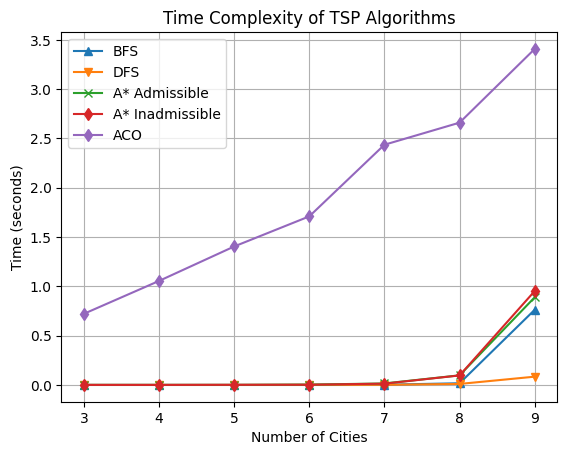

In [15]:
import time
num_cities_range = range(3, 10)
times_bfs = []
times_dfs = []
times_astar_admissible = []
times_astar_inadmissible = []
times_aco = []

for num_cities in num_cities_range:
    cities = generate_cities(num_cities)
    graph = create_graph(cities, connections_percentage=1.0, symmetrical=True)
    
    start_city = 0


    
    start_time = time.time()
    tsp_bfs(graph, start_city)
    end_time = time.time()
    times_bfs.append(end_time - start_time)
    
    start_time = time.time()
    tsp_dfs(graph, start_city)
    end_time = time.time()
    times_dfs.append(end_time - start_time)
    
    start_time = time.time()
    tsp_a_star(graph, start_city)
    end_time = time.time()
    times_astar_admissible.append(end_time - start_time)
    
    start_time = time.time()
    tsp_a_star(graph, start_city)
    end_time = time.time()
    times_astar_inadmissible.append(end_time - start_time)
    
    start_time = time.time()
    ant_colony_optimization(graph, num_ants, num_iterations)
    end_time = time.time()
    times_aco.append(end_time - start_time)


plt.plot(num_cities_range, times_bfs, marker='^', label='BFS')
plt.plot(num_cities_range, times_dfs, marker='v', label='DFS')
plt.plot(num_cities_range, times_astar_admissible, marker='x', label='A* Admissible')
plt.plot(num_cities_range, times_astar_inadmissible, marker='d', label='A* Inadmissible')
plt.plot(num_cities_range, times_aco, marker='d', label='ACO')
plt.xlabel('Number of Cities')
plt.ylabel('Time (seconds)')
plt.title('Time Complexity of TSP Algorithms')
plt.legend()
plt.grid(True)
plt.show()